In [1]:
import numpy as np
import pandas as pd
import vectorbtpro as vbt

In [2]:
## Load m1 data
m1_data = vbt.HDFData.fetch('../data/GU_OHLCV_3Y.h5')
m1_data.wrapper.index #pandas doaesn't recognise the frequency because of missing timestamps

DatetimeIndex(['2019-08-27 00:00:00+00:00', '2019-08-27 00:01:00+00:00',
               '2019-08-27 00:02:00+00:00', '2019-08-27 00:03:00+00:00',
               '2019-08-27 00:04:00+00:00', '2019-08-27 00:05:00+00:00',
               '2019-08-27 00:06:00+00:00', '2019-08-27 00:07:00+00:00',
               '2019-08-27 00:08:00+00:00', '2019-08-27 00:09:00+00:00',
               ...
               '2022-08-26 16:50:00+00:00', '2022-08-26 16:51:00+00:00',
               '2022-08-26 16:52:00+00:00', '2022-08-26 16:53:00+00:00',
               '2022-08-26 16:54:00+00:00', '2022-08-26 16:55:00+00:00',
               '2022-08-26 16:56:00+00:00', '2022-08-26 16:57:00+00:00',
               '2022-08-26 16:58:00+00:00', '2022-08-26 16:59:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1122468, freq=None)

In [3]:
m5_data  = m1_data.resample('5T')   # Convert 1 minute to 5 mins
m15_data = m1_data.resample('15T')  # Convert 1 minute to 15 mins
m30_data = m1_data.resample('30T')  # Convert 1 minute to 30 mins
h1_data = m1_data.resample("1h")    # Convert 1 minute to 1 hour
h4_data = m1_data.resample("4h")    # Convert 1 minute to 4 hour
d1_data = m1_data.resample("1d")    # Convert 1 minute to daily

In [4]:
# Obtain all the closing  prices using the .get() method
m5_close = m5_data.get()['Close'].ffill()
m15_close = m15_data.get()['Close']

##m30 data
m30_open  = m30_data.get()['Open']
m30_close = m30_data.get()['Close']
m30_high  = m30_data.get()['High']
m30_low   = m30_data.get()['Low']

## h1 data
h1_open  = h1_data.get()['Open']
h1_close = h1_data.get()['Close']
h1_high  = h1_data.get()['High']
h1_low   = h1_data.get()['Low']

## h4 data
h4_open  = h4_data.get()['Open']
h4_close = h4_data.get()['Close']
h4_high  = h4_data.get()['High']
h4_low   = h4_data.get()['Low']

## 1D data
d1_open  = d1_data.get()['Open']
d1_close = d1_data.get()['Close']
d1_high  = d1_data.get()['High']
d1_low   = d1_data.get()['Low']

### Creating the Indicators for multi-timeframes

In [5]:
## Method 1 - Manual of method of MTF Indicator creation
rsi_period = 21

## 5m indicators
m5_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m5_data.get("Close"), skipna=True).real
m5_bbands = vbt.talib("BBANDS").run(m5_data.get("Close"), skipna=True)
m5_bbands_rsi = vbt.talib("BBANDS").run(m5_rsi, skipna=True)

## 15m indicators
m15_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m15_data.get("Close"), skipna=True).real
m15_bbands = vbt.talib("BBANDS").run(m15_data.get("Close"), skipna=True)
m15_bbands_rsi = vbt.talib("BBANDS").run(m15_rsi, skipna=True)

## 30m indicators
m30_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m30_data.get("Close"), skipna=True).real
m30_bbands = vbt.talib("BBANDS").run(m30_data.get("Close"), skipna=True)
m30_bbands_rsi = vbt.talib("BBANDS").run(m30_rsi, skipna=True)

## h1 indicators
h1_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(h1_data.get("Close"), skipna=True).real
h1_bbands = vbt.talib("BBANDS").run(h1_data.get("Close"), skipna=True)
h1_bbands_rsi = vbt.talib("BBANDS").run(h1_rsi, skipna=True)

## h4 indicators
h4_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(h4_data.get("Close"), skipna=True).real
h4_bbands = vbt.talib("BBANDS").run(h4_data.get("Close"), skipna=True)
h4_bbands_rsi = vbt.talib("BBANDS").run(h4_rsi, skipna=True)

### Resample and creating a multi-time frame dataframe

Upsampling higher timeframe (`low frequency`) data to lower timeframe (`high frequency`) data

In [6]:
def create_resamplers(result_dict_keys_list : list, source_indices : list,  source_frequencies :list, target_index : pd.Series, target_freq : str):
    """
    Creates a dictionary of vbtpro resampler objects.

    Parameters
    ==========
    result_dict_keys_list : list, list of strings, which are keys of the output dictionary
    source_indices        : list, list of pd.time series objects of the higher timeframes
    source_frequencies    : list, list of strings, which are short form representation of the time series order. Eg:["1D", "4h"]
    target_index          : pd.Series, target time series for the resampler objects
    target_freq           : str, target time frequency for the resampler objects,
                            use the 1st frequency in source_frequencies list

    Returns
    ===========
    
    resamplers_dict       : dict, vbt pro resampler objects
    
    """
    
    
    resamplers = []
    for si, sf in zip(source_indices, source_frequencies):
        resamplers.append(vbt.Resampler(source_index = si,  target_index = target_index,  source_freq=sf, target_freq=target_freq))
    return dict(zip(result_dict_keys_list, resamplers))

In [7]:
## Create Resampler Objects for upsampling
src_indices = [m15_close.index, m30_close.index, h1_close.index, h4_close.index, d1_close.index ]
src_frequencies = ["15T","30T", "1h", "4h", "1D"]
resampler_dict_keys = ["m15_m5", "m30_m5", "h1_m5", "h4_m5", "d1_m5"]

list_resamplers = create_resamplers(resampler_dict_keys, src_indices, src_frequencies, m15_close.index, "15T")
list_resamplers

{'m15_m5': <vectorbtpro.base.resampling.base.Resampler at 0x29a55ce20>,
 'm30_m5': <vectorbtpro.base.resampling.base.Resampler at 0x29a55e5f0>,
 'h1_m5': <vectorbtpro.base.resampling.base.Resampler at 0x29a55cee0>,
 'h4_m5': <vectorbtpro.base.resampling.base.Resampler at 0x29a55e4a0>,
 'd1_m5': <vectorbtpro.base.resampling.base.Resampler at 0x29a55dea0>}

In [8]:
## Initialize  dictionary

data = {"m5_close" : m5_close.ffill(), "m5_rsi" : m5_rsi.ffill(), 
        "m5_bband_price_upper" : m5_bbands.upperband.ffill(),  "m5_bband_price_middle" : m5_bbands.middleband.ffill(),  "m5_bband_price_lower" : m5_bbands.lowerband.ffill(),
        "m5_bband_rsi_upper" : m5_bbands_rsi.upperband.ffill(),  "m5_bband_rsi_middle" : m5_bbands_rsi.middleband.ffill(), "m5_bband_rsi_lower" : m5_bbands_rsi.lowerband.ffill() 
        }

In [9]:
## Use along with method 1 - Manual indicator creation for MTF
series_to_resample = [
    # [m5_close, m5_rsi, m5_bbands.upperband, m5_bbands.middleband, m5_bbands.lowerband, m5_bbands_rsi.upperband, m5_bbands_rsi.middleband, m5_bbands_rsi.lowerband],
    [m15_close, m15_rsi, m15_bbands.upperband, m15_bbands.middleband, m15_bbands.lowerband, m15_bbands_rsi.upperband, m15_bbands_rsi.middleband, m15_bbands_rsi.lowerband],
    [m30_close, m30_rsi, m30_bbands.upperband, m30_bbands.middleband, m30_bbands.lowerband, m30_bbands_rsi.upperband, m30_bbands_rsi.middleband, m30_bbands_rsi.lowerband],
    [h1_close, h1_rsi, h1_bbands.upperband, h1_bbands.middleband, h1_bbands.lowerband, h1_bbands_rsi.upperband, h1_bbands_rsi.middleband, h1_bbands_rsi.lowerband],
    [h4_close, h4_rsi, h4_bbands.upperband, h4_bbands.middleband, h4_bbands.lowerband, h4_bbands_rsi.upperband, h4_bbands_rsi.middleband, h4_bbands_rsi.lowerband],
    # [d1_close, d1_rsi, d1_bbands.upperband, d1_bbands.middleband, d1_bbands.lowerband, d1_bbands_rsi.upperband, d1_bbands_rsi.middleband, d1_bbands_rsi.lowerband]
    ]

data_keys = [
    # ["m5_close", "m5_rsi", "m5_bband_price_upper", "m5_bband_price_middle", "m5_bband_price_lower", "m5_bband_rsi_upper", "m5_bband_rsi_middle", "m5_bband_rsi_lower"],
    ["m15_close", "m15_rsi", "m15_bband_price_upper",  "m15_bband_price_middle", "m15_bband_price_lower",  "m15_bband_rsi_upper",  "m15_bband_rsi_middle", "m15_bband_rsi_lower"], 
    ["m30_close", "m30_rsi", "m30_bband_price_upper",  "m30_bband_price_middle", "m30_bband_price_lower",  "m30_bband_rsi_upper",  "m30_bband_rsi_middle", "m30_bband_rsi_lower"],
    ["h1_close", "h1_rsi", "h1_bband_price_upper",  "h1_bband_price_middle",  "h1_bband_price_lower",  "h1_bband_rsi_upper",  "h1_bband_rsi_middle", "h1_bband_rsi_lower" ],
    ["h4_close", "h4_rsi", "h4_bband_price_upper",  "h4_bband_price_middle",  "h4_bband_price_lower",  "h4_bband_rsi_upper",  "h4_bband_rsi_middle", "h4_bband_rsi_lower" ],
    # ["d1_close", "d1_rsi", "d1_bband_price_upper",  "d1_bband_price_middle",  "d1_bband_price_lower",  "d1_bband_rsi_upper",  "d1_bband_rsi_middle", "d1_bband_rsi_lower" ]
         ]

In [10]:
## Use this along with Method 1 of indicator creation

for lst_series, lst_keys, resampler in zip(series_to_resample, data_keys, resampler_dict_keys):
    for key, time_series in zip(lst_keys, lst_series):
        resampled_time_series = time_series.vbt.resample_closing(list_resamplers[resampler])
        data[key] = resampled_time_series.ffill()

In [11]:
## Add m30 OLH data
# data["m30_open"] = m30_open.vbt.resample_closing(list_resamplers['m30_m5']).ffill()
# data["m30_low"]  = m30_low.vbt.resample_closing(list_resamplers['m30_m5']).ffill()
# data["m30_high"] = m30_high.vbt.resample_closing(list_resamplers['m30_m5']).ffill()

## Add h1 OLH data
data["h1_open"] = h1_open.vbt.resample_closing(list_resamplers['h1_m5']).ffill()
data["h1_low"]  = h1_low.vbt.resample_closing(list_resamplers['h1_m5']).ffill()
data["h1_high"] = h1_high.vbt.resample_closing(list_resamplers['h1_m5']).ffill()

## Add h4 OLH data
data["h4_open"] = h4_open.vbt.resample_closing(list_resamplers['h4_m5']).ffill()
data["h4_low"]  = h4_low.vbt.resample_closing(list_resamplers['h4_m5']).ffill()
data["h4_high"] = h4_high.vbt.resample_closing(list_resamplers['h4_m5']).ffill()

Constructing DataFrame of Multi-Time Frame Data

In [12]:
## construct a multi-timeframe dataframe
mtf_df = pd.DataFrame(data)
print("Length of mtf_df:",len(mtf_df), f'on {mtf_df.index.freq} frequency')

Length of mtf_df: 315564 on <5 * Minutes> frequency


In [13]:
display(mtf_df)

,m5_close,m5_rsi,m5_bband_price_upper,m5_bband_price_middle,m5_bband_price_lower,m5_bband_rsi_upper,m5_bband_rsi_middle,m5_bband_rsi_lower,m15_close,m15_rsi,...,h4_bband_price_lower,h4_bband_rsi_upper,h4_bband_rsi_middle,h4_bband_rsi_lower,h1_open,h1_low,h1_high,h4_open,h4_low,h4_high
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221165,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:05:00+00:00,1.221280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:10:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:15:00+00:00,1.221145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:20:00+00:00,1.221595,NaN,1.221619,1.221297,1.220975,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26 16:35:00+00:00,1.173785,40.177989,1.174308,1.173867,1.173426,45.681371,40.345471,35.009572,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-26 16:40:00+00:00,1.173915,41.774054,1.174169,1.173954,1.173739,43.384374,41.640093,39.895813,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-26 16:45:00+00:00,1.173885,41.505727,1.174141,1.173929,1.173717,43.325590,41.585151,39.844713,1.174355,37.158814,...,1.172483,47.617494,42.127199,36.636905,1.173765,1.173405,1.17439,1.17749,1.17354,1.17836


In [14]:
mtf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315564 entries, 2019-08-27 00:00:00+00:00 to 2022-08-26 16:55:00+00:00
Freq: 5T
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   m5_close                315564 non-null  float64
 1   m5_rsi                  315543 non-null  float64
 2   m5_bband_price_upper    315560 non-null  float64
 3   m5_bband_price_middle   315560 non-null  float64
 4   m5_bband_price_lower    315560 non-null  float64
 5   m5_bband_rsi_upper      315539 non-null  float64
 6   m5_bband_rsi_middle     315539 non-null  float64
 7   m5_bband_rsi_lower      315539 non-null  float64
 8   m15_close               105188 non-null  float64
 9   m15_rsi                 105167 non-null  float64
 10  m15_bband_price_upper   105184 non-null  float64
 11  m15_bband_price_middle  105184 non-null  float64
 12  m15_bband_price_lower   105184 non-null  float64
 13  m15_bband_rsi_upper

### Double Bollinger Band - Strategy Conditions
The trading conditions (rules) of the strategy are as follows:

1. A long (buy) signal is generated whenever the H4 market (Low) price surpasses its lower Bollinger band after having been below it while simultaneously, the 5m RSI surpasses its lower Bollinger band after having been below it.

2. A short (sell) signal is generated whenever the H4 market (High) price breaks its upper Bollinger band after having been above it while simultaneously, the 5m RSI breaks below its upper Bollinger band after having been above it.

In [15]:
required_cols = ['m5_close', "m5_rsi" , "m5_bband_rsi_lower", "m5_bband_rsi_upper" ,
                #  "h1_low", "h1_rsi" , "h1_bband_price_lower" ,
                 'h4_low', "h4_rsi", "h4_bband_price_lower"]

In [16]:
mtf_df[required_cols][(mtf_df['h4_low'] < mtf_df['h4_bband_price_lower'])]

,m5_close,m5_rsi,m5_bband_rsi_lower,m5_bband_rsi_upper,h4_low,h4_rsi,h4_bband_price_lower
time,,,,,,,
2019-08-28 07:45:00+00:00,1.221840,51.335316,50.615536,52.485716,1.21560,NaN,1.220568
2019-08-28 08:00:00+00:00,1.221250,48.294728,45.907702,53.849016,1.21560,NaN,1.220568
2019-08-28 08:15:00+00:00,1.219830,41.430970,40.153428,49.817410,1.21560,NaN,1.220568
2019-08-28 08:30:00+00:00,1.220750,47.167996,39.710691,48.253922,1.21560,NaN,1.220568
2019-08-28 08:45:00+00:00,1.220675,47.215114,43.960790,48.814173,1.21560,NaN,1.220568
...,...,...,...,...,...,...,...
2022-08-26 14:30:00+00:00,1.174595,36.699243,35.572356,38.362417,1.17539,41.062856,1.176465
2022-08-26 14:45:00+00:00,1.174360,36.947733,35.259362,40.877419,1.17539,41.062856,1.176465
2022-08-26 15:00:00+00:00,1.173835,34.425923,34.214479,39.590615,1.17539,41.062856,1.176465


In [17]:
## Higher values greater than 1.0 are like moving up the lower RSI b-band, signifying if the lowerband rsi is anywhere around 1% of the lower b-band validate that case as True
bb_upper_fract = 0.99
bb_lower_fract = 1.01

In [18]:
## When additional checking if RSI goes below 30 it Yields very few results
mtf_df[required_cols][(mtf_df['m5_rsi'] < (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) ) & (mtf_df['m5_rsi'] <= 30)]

,m5_close,m5_rsi,m5_bband_rsi_lower,m5_bband_rsi_upper,h4_low,h4_rsi,h4_bband_price_lower
time,,,,,,,
2019-09-02 05:35:00+00:00,1.208470,25.096979,24.974743,27.263093,NaN,NaN,NaN
2019-09-25 06:55:00+00:00,1.241430,29.006439,28.988739,48.488634,NaN,NaN,NaN
2019-10-01 08:25:00+00:00,1.224075,27.174164,27.076053,33.364587,NaN,NaN,NaN
2019-10-01 09:40:00+00:00,1.221595,29.589859,29.351173,31.926811,NaN,NaN,NaN
2019-10-02 02:55:00+00:00,1.225940,29.485664,29.365420,32.536738,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-08-03 09:55:00+00:00,1.213165,27.029353,26.783297,41.892813,NaN,NaN,NaN
2022-08-04 20:35:00+00:00,1.214385,29.739683,29.537824,34.476335,NaN,NaN,NaN
2022-08-08 12:55:00+00:00,1.207655,28.467812,28.350170,31.495490,NaN,NaN,NaN


In [19]:
mtf_df[required_cols][(mtf_df['m5_rsi'] < (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) )]

,m5_close,m5_rsi,m5_bband_rsi_lower,m5_bband_rsi_upper,h4_low,h4_rsi,h4_bband_price_lower
time,,,,,,,
2019-08-27 02:55:00+00:00,1.221580,47.784063,47.618846,76.466612,NaN,NaN,NaN
2019-08-27 04:00:00+00:00,1.224435,63.581957,63.041556,74.754474,1.22090,NaN,NaN
2019-08-27 04:35:00+00:00,1.224555,61.954159,61.526209,63.600820,NaN,NaN,NaN
2019-08-27 04:40:00+00:00,1.224565,62.030455,61.482481,63.161079,NaN,NaN,NaN
2019-08-27 06:45:00+00:00,1.226155,58.153524,57.998605,66.636332,1.22090,NaN,NaN
...,...,...,...,...,...,...,...
2022-08-26 13:15:00+00:00,1.174690,33.142010,32.871570,36.166223,1.17539,41.062856,1.176465
2022-08-26 14:05:00+00:00,1.175055,38.236679,37.955778,40.677342,NaN,NaN,NaN
2022-08-26 15:00:00+00:00,1.173835,34.425923,34.214479,39.590615,1.17539,41.062856,1.176465


In [20]:
## Final conditions - Using m5 and h4 data 
mtf_df['long_entry'] = (mtf_df['h4_low'] <= mtf_df['h4_bband_price_lower']) & (mtf_df['m5_rsi'] <= (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) )
mtf_df['long_exit']  = (mtf_df['h4_high'] >= mtf_df['h4_bband_price_upper']) & (mtf_df['m5_rsi'] >= (bb_upper_fract * mtf_df['m5_bband_rsi_upper']))


In [21]:
mtf_df['signal'] = 0   
mtf_df['signal'] = np.where( mtf_df['long_entry'] ,1, 0)
mtf_df['signal'] = np.where( mtf_df['long_exit'] ,-1, mtf_df['signal'])

In [22]:
long_entries = mtf_df.signal == 1.0
long_exits = mtf_df.signal == -1.0

mtf_df['short_entries'] = short_entries = long_exits
mtf_df['short_exits'] = short_exits = long_entries

mtf_df.drop(columns="signal", axis=1, inplace = True)
mtf_df.head()

,m5_close,m5_rsi,m5_bband_price_upper,m5_bband_price_middle,m5_bband_price_lower,m5_bband_rsi_upper,m5_bband_rsi_middle,m5_bband_rsi_lower,m15_close,m15_rsi,...,h1_open,h1_low,h1_high,h4_open,h4_low,h4_high,long_entry,long_exit,short_entries,short_exits
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221165,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2019-08-27 00:05:00+00:00,1.221280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2019-08-27 00:10:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2019-08-27 00:15:00+00:00,1.221145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2019-08-27 00:20:00+00:00,1.221595,NaN,1.221619,1.221297,1.220975,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False


_Cleaning_ `entries` and `exit` signals by removing redundant signals

In [23]:
print(long_entries.vbt.signals.total(),long_exits.vbt.signals.total(),short_entries.vbt.signals.total(), short_exits.vbt.signals.total())
print(len(long_entries), len(long_exits), len(short_entries), len(short_exits))

940 969 969 940
315564 315564 315564 315564


In [24]:
## Clean redundant and duplicate signals
clean_long_entries, clean_long_exits = long_entries.vbt.signals.clean(long_exits)
clean_short_entries, clean_short_exits = short_entries.vbt.signals.clean(short_exits)

In [25]:
print(clean_long_entries.vbt.signals.total(),clean_long_exits.vbt.signals.total(), 
      clean_short_entries.vbt.signals.total(),clean_short_exits.vbt.signals.total())
print(len(clean_long_entries), len(clean_long_exits), len(clean_short_entries), len(clean_short_exits))

330 329 329 329
315564 315564 315564 315564


Resampling `entries` and `exits` from `5m` to `H4` for plotting purpose

In [26]:
%%time
## Faster method
h4_long_entries = long_entries.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))
h4_long_exits = long_exits.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))
h4_short_entries = short_entries.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))
h4_short_exits = short_exits.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))

CPU times: user 174 ms, sys: 4.45 ms, total: 179 ms
Wall time: 178 ms


In [27]:
print(len(h4_long_entries),len(h4_long_exits),len(h4_short_entries),len(h4_short_exits))
print(h4_long_entries.vbt.signals.total(),h4_long_exits.vbt.signals.total(),
      h4_short_entries.vbt.signals.total(),h4_short_exits.vbt.signals.total())

6575 6575 6575 6575
666 645 645 666


In [28]:
clean_h4_long_entries, clean_h4_long_exits = h4_long_entries.vbt.signals.clean(h4_long_exits)
clean_h4_short_entries, clean_h4_short_exits = h4_short_entries.vbt.signals.clean(h4_short_exits)

In [29]:
print(len(clean_h4_long_entries),len(clean_h4_long_exits),len(clean_h4_short_entries),len(clean_h4_short_exits))
print(clean_h4_long_entries.vbt.signals.total(),clean_h4_long_exits.vbt.signals.total(), \
      clean_h4_short_entries.vbt.signals.total(),clean_h4_short_exits.vbt.signals.total())

6575 6575 6575 6575
248 247 247 247


### Plotting Indicators

In [30]:
## Global Plot Settings
vbt.settings.set_theme("dark")
vbt.settings['plotting']['layout']['width'] = 1280

In [31]:
## Acquire Data for Indicators Plot
h4_df = h4_data.get()
h4_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(h4_data.get("Close"), skipna=True).real
h4_bbands = vbt.talib("BBANDS").run(h4_data.get("Close"), skipna=True)
h4_bbands_rsi = vbt.talib("BBANDS").run(h4_rsi, skipna=True)
h4_df

,Open,High,Low,Close,Volume
time,,,,,
2019-08-27 00:00:00+00:00,1.221095,1.225280,1.220900,1.225030,3.087917e+10
2019-08-27 04:00:00+00:00,1.225045,1.227655,1.224060,1.226965,4.512783e+10
2019-08-27 08:00:00+00:00,1.226960,1.231000,1.225215,1.228735,6.021476e+10
2019-08-27 12:00:00+00:00,1.228740,1.230380,1.228095,1.228765,2.032644e+10
2019-08-27 16:00:00+00:00,1.228780,1.229225,1.228045,1.228070,7.616710e+09
...,...,...,...,...,...
2022-08-26 00:00:00+00:00,1.182580,1.182615,1.177895,1.178830,1.852738e+10
2022-08-26 04:00:00+00:00,1.178845,1.184380,1.177785,1.182145,2.676285e+10
2022-08-26 08:00:00+00:00,1.182135,1.189770,1.175390,1.177480,7.900152e+10


### Creating Stacked SubPlots on Sliced Data

In [32]:
def stacked_2bb_rsi_plot(slice_lower : str, slice_upper: str, df : pd.DataFrame , rsi : pd.Series,
                         bb_price : vbt.indicators.factory, bb_rsi : vbt.indicators.factory, 
                         long_entries: pd.Series, long_exits: pd.Series, 
                         short_entries: pd.Series, short_exits: pd.Series,
                         show_legend : bool = True):
    """Creates a stacked indicator plot for the 2BB strategy.
    Parameters
    ===========
    slice_lower : str, start date of dataframe slice in yyyy.mm.dd format
    slice_upper : str, start date of dataframe slice in yyyy.mm.dd format
    df          : pd.DataFrame, containing the OHLCV data
    rsi         : pd.Series, rsi indicator time series in same freq as df
    bb_price    : vbt.indicators.factory.talib('BBANDS'), computed on df['close'] price
    bb_rsi      : vbt.indicators.factory.talib('BBANDS') computer on RSI
    long_entries: pd.Series, time series data of long entries
    long_exits  : pd.Series, time series data of long exits
    short_entries: pd.Series, time series data of short entries
    short_exits : pd.Series, time series data of short exits
    show_legend : bool, switch to show or completely hide the legend box on the plot
    
    Returns
    =======
    fig         : plotly figure object
    """
    kwargs1 = {"title_text" : "H4 OHLCV with BBands on Price and RSI", 
               "title_font_size" : 18,
               "height" : 960,
               "legend" : dict(yanchor="top",y=0.99, xanchor="right",x= 0.1)}
    fig = vbt.make_subplots(rows=2,cols=1, shared_xaxes=True, vertical_spacing=0.1)
    ## Filter Data according to date slice
    df_slice = df[["Open", "High", "Low", "Close"]][slice_lower : slice_upper]
    bb_price = bb_price[slice_lower : slice_upper]
    rsi = rsi[slice_lower : slice_upper]
    bb_rsi = bb_rsi[slice_lower : slice_upper]
    long_entries = long_entries[slice_lower : slice_upper]
    long_exits = long_exits[slice_lower : slice_upper]
    short_entries = short_entries[slice_lower : slice_upper]
    short_exits = short_exits[slice_lower : slice_upper]    

    ## Retrieve datetime index of rows where price data is NULL
    # retrieve the dates that are in the original datset
    dt_obs = df_slice.index.to_list()
    # Drop rows with missing values
    dt_obs_dropped = df_slice['Close'].dropna().index.to_list()
    # store  dates with missing values
    dt_breaks = [d for d in dt_obs if d not in dt_obs_dropped]

    ## Plot Figures
    df_slice.vbt.ohlcv.plot(add_trace_kwargs=dict(row=1, col=1),  fig=fig, **kwargs1) ## Without Range Slider
    rsi.rename("RSI").vbt.plot(add_trace_kwargs=dict(row=2, col=1), trace_kwargs = dict(connectgaps=True), fig=fig, **kwargs1 ) 

    bb_price.plot(add_trace_kwargs=dict(row=1, col=1),fig=fig, **kwargs1,
                    lowerband_trace_kwargs=dict(fill=None, name = 'BB_Price_Lower', connectgaps=True), 
                    upperband_trace_kwargs=dict(fill=None, name = 'BB_Price_Upper', connectgaps=True),
                    middleband_trace_kwargs=dict(fill=None, name = 'BB_Price_Middle', connectgaps=True) )

    bb_rsi.plot(add_trace_kwargs=dict(row=2, col=1),limits=(25, 75),fig=fig,
                lowerband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Lower', connectgaps=True), 
                upperband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Upper', connectgaps=True),
                middleband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Middle', connectgaps=True))

    ## Add Long Entries and Long Exits
    long_entries.vbt.signals.plot_as_entries(bb_price.lowerband,fig=fig,
                                            trace_kwargs=dict(marker=dict(color="limegreen"), 
                                                              name="Long entries")
                                            )
    long_exits.vbt.signals.plot_as_exits(bb_price.upperband, fig = fig,
                                        trace_kwargs=dict(marker=dict(color="red"), 
                                                          name="Long exits"), 
                                        )
    long_entries.vbt.signals.plot_as_entries(bb_rsi.lowerband, fig = fig,
                                             add_trace_kwargs=dict(row=2, col=1),
                                             trace_kwargs=dict(marker=dict(color="limegreen"),
                                                               showlegend = False))  

    long_exits.vbt.signals.plot_as_exits(bb_rsi.upperband, fig = fig,showlegend = False,
                                         add_trace_kwargs=dict(row=2, col=1),
                                         trace_kwargs=dict(marker=dict(color="red"),
                                                           showlegend = False))

    ## Add Short Entries and Short Exits
    shot_entry_marker_style = dict(color="lightgreen",symbol="circle-open",size = 15)
    short_exit_marker_style = dict(color="red", symbol="circle-open", size = 15)
    
    short_entries.vbt.signals.plot_as_entries(bb_price.upperband, fig=fig,
                                              trace_kwargs=dict(name="Short entries",
                                                                marker=shot_entry_marker_style,
                                              ))
    short_exits.vbt.signals.plot_as_exits(bb_price.lowerband, fig = fig,
                                          trace_kwargs=dict(name="Short exits",
                                                            marker=short_exit_marker_style,
                                          ))
    short_entries.vbt.signals.plot_as_entries(bb_rsi.upperband, fig = fig,
                                              add_trace_kwargs=dict(row=2, col=1),
                                              trace_kwargs=dict(marker = shot_entry_marker_style,
                                                                showlegend = False)
                                              )  
                                                
    short_exits.vbt.signals.plot_as_exits(bb_rsi.lowerband,fig = fig,
                                          add_trace_kwargs=dict(row=2, col=1),
                                          trace_kwargs=dict(marker = short_exit_marker_style,
                                                            showlegend = False)
                                          )      

    fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])
    fig.layout.showlegend = show_legend  
    fig.write_html(f"2BB_Strategy_{slice_lower}_to_{slice_upper}.html")
    
    return fig

In [33]:
slice_lower = '2019.10.01'
slice_higher = '2019.10.30'
fig = stacked_2bb_rsi_plot(slice_lower, slice_higher, h4_df, h4_rsi, 
                           h4_bbands, h4_bbands_rsi, 
                           clean_h4_long_entries, clean_h4_long_exits, 
                           clean_h4_short_entries, clean_h4_short_exits,
                           show_legend = True)
fig.show()

Create Backtest Simulation for 2BB Strategy using `vbt.Portfolio.from_signals()`

In [34]:
pf_2_bb_custom = vbt.Portfolio.from_signals(
    mtf_df['m5_close'], 
    entries=long_entries, 
    exits=long_exits, 
    short_entries=short_entries, 
    short_exits=short_exits, 
    freq=pd.Timedelta(minutes=5), 
    init_cash=100000
)

In [35]:
pf_2_bb_custom.stats()

Start                         2019-08-27 00:00:00+00:00
End                           2022-08-26 16:55:00+00:00
Period                               1095 days 17:00:00
Start Value                                    100000.0
Min Value                                  89464.596796
Max Value                                 123342.770438
End Value                                 115115.249603
Total Return [%]                               15.11525
Benchmark Return [%]                          -3.843855
Total Time Exposure [%]                       99.870708
Max Gross Exposure [%]                       107.462939
Max Drawdown [%]                               11.85588
Max Drawdown Duration                 252 days 04:00:00
Total Orders                                        659
Total Fees Paid                                     0.0
Total Trades                                        659
Win Rate [%]                                  57.598784
Best Trade [%]                                  

In [36]:
# pf_2_bb_custom.plot().show() ## This takes too long (30 secs) as it uses 5m timeframe
pf_2_bb_custom.resample("1d").plot().show()

In [37]:
# pf_2_bb_custom.orders.plot(xaxis=dict(rangeslider_visible=True),**kwargs1).show()
kwargs1 = {"title_text" : "Orders - Stats & Plot", "title_font_size" : 18}
pf_2_bb_custom.orders.resample("1d").plot(xaxis=dict(rangeslider_visible=True),**kwargs1).show()

<AxesSubplot: >

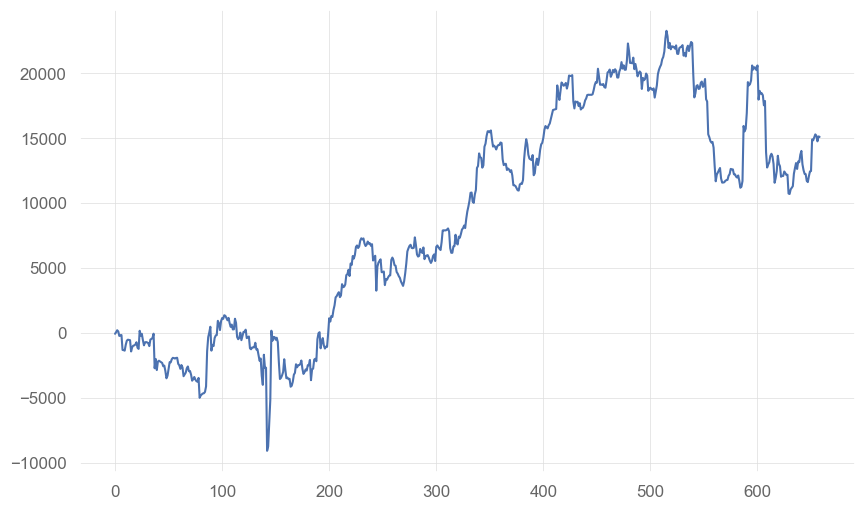

In [38]:
## Simple line plots seem to be using matplotlib
pf_2_bb_custom.trades.records_readable.PnL.cumsum().plot()

In [39]:
pf_2_bb_custom.trades.records_readable

,Exit Trade Id,Column,Size,Entry Index,Avg Entry Price,Entry Fees,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,81925.914396,2019-08-28 10:00:00+00:00,1.220615,0.0,2019-08-29 12:00:00+00:00,1.219970,0.0,-52.842215,-0.000528,Long,Closed,0
1,1,0,81925.914396,2019-08-29 12:00:00+00:00,1.219970,0.0,2019-08-30 08:15:00+00:00,1.218425,0.0,126.575538,0.001266,Short,Closed,1
2,2,0,82133.683504,2019-08-30 08:15:00+00:00,1.218425,0.0,2019-08-30 09:30:00+00:00,1.220210,0.0,146.608625,0.001465,Long,Closed,2
3,3,0,82133.683504,2019-08-30 09:30:00+00:00,1.220210,0.0,2019-08-30 10:30:00+00:00,1.221320,0.0,-91.168389,-0.000910,Short,Closed,3
4,4,0,81984.388661,2019-08-30 10:30:00+00:00,1.221320,0.0,2019-08-30 12:15:00+00:00,1.217090,0.0,-346.793964,-0.003463,Long,Closed,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,654,0,97561.552116,2022-08-24 06:00:00+00:00,1.179620,0.0,2022-08-25 00:00:00+00:00,1.181860,0.0,218.537877,0.001899,Long,Closed,654
655,655,0,97561.552116,2022-08-25 00:00:00+00:00,1.181860,0.0,2022-08-26 05:45:00+00:00,1.182965,0.0,-107.805515,-0.000935,Short,Closed,655
656,656,0,97379.288879,2022-08-26 05:45:00+00:00,1.182965,0.0,2022-08-26 11:45:00+00:00,1.178580,0.0,-427.008182,-0.003707,Long,Closed,656
657,657,0,97379.288879,2022-08-26 11:45:00+00:00,1.178580,0.0,2022-08-26 13:15:00+00:00,1.174690,0.0,378.805434,0.003301,Short,Closed,657


In [40]:
pnl_series = pf_2_bb_custom.trades.pnl.to_pd()
pnl_series[pnl_series.notna()]

time
2019-08-29 12:00:00+00:00    -52.842215
2019-08-30 08:15:00+00:00    126.575538
2019-08-30 09:30:00+00:00    146.608625
2019-08-30 10:30:00+00:00    -91.168389
2019-08-30 12:15:00+00:00   -346.793964
                                ...    
2022-08-25 00:00:00+00:00    218.537877
2022-08-26 05:45:00+00:00   -107.805515
2022-08-26 11:45:00+00:00   -427.008182
2022-08-26 13:15:00+00:00    378.805434
2022-08-26 16:55:00+00:00    -32.838118
Length: 659, dtype: float64

### Save final dataframe with consolidated signals and `P&L`

In [41]:
## Map Signals column into relavant integers to represent long and short entry/exit signals
signal = long_entries.copy()
signal.loc[:] = 0
signal.loc[clean_long_entries] = 2
signal.loc[clean_long_exits] = 1
signal.loc[clean_short_entries] = -2
signal.loc[clean_short_exits] = -1

In [42]:
mtf_df['cleaned_signal'] = signal
mtf_df["pnl"] = pnl_series
mtf_df

,m5_close,m5_rsi,m5_bband_price_upper,m5_bband_price_middle,m5_bband_price_lower,m5_bband_rsi_upper,m5_bband_rsi_middle,m5_bband_rsi_lower,m15_close,m15_rsi,...,h1_high,h4_open,h4_low,h4_high,long_entry,long_exit,short_entries,short_exits,cleaned_signal,pnl
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221165,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,0,NaN
2019-08-27 00:05:00+00:00,1.221280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,0,NaN
2019-08-27 00:10:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,0,NaN
2019-08-27 00:15:00+00:00,1.221145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,0,NaN
2019-08-27 00:20:00+00:00,1.221595,NaN,1.221619,1.221297,1.220975,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26 16:35:00+00:00,1.173785,40.177989,1.174308,1.173867,1.173426,45.681371,40.345471,35.009572,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,0,NaN
2022-08-26 16:40:00+00:00,1.173915,41.774054,1.174169,1.173954,1.173739,43.384374,41.640093,39.895813,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,0,NaN
2022-08-26 16:45:00+00:00,1.173885,41.505727,1.174141,1.173929,1.173717,43.325590,41.585151,39.844713,1.174355,37.158814,...,1.17439,1.17749,1.17354,1.17836,False,False,False,False,0,NaN


In [43]:
mtf_df.to_csv("2BB_Final_Simulation.csv", index = False)

In [44]:
mtf_df.columns

Index(['m5_close', 'm5_rsi', 'm5_bband_price_upper', 'm5_bband_price_middle',
       'm5_bband_price_lower', 'm5_bband_rsi_upper', 'm5_bband_rsi_middle',
       'm5_bband_rsi_lower', 'm15_close', 'm15_rsi', 'm15_bband_price_upper',
       'm15_bband_price_middle', 'm15_bband_price_lower',
       'm15_bband_rsi_upper', 'm15_bband_rsi_middle', 'm15_bband_rsi_lower',
       'm30_close', 'm30_rsi', 'm30_bband_price_upper',
       'm30_bband_price_middle', 'm30_bband_price_lower',
       'm30_bband_rsi_upper', 'm30_bband_rsi_middle', 'm30_bband_rsi_lower',
       'h1_close', 'h1_rsi', 'h1_bband_price_upper', 'h1_bband_price_middle',
       'h1_bband_price_lower', 'h1_bband_rsi_upper', 'h1_bband_rsi_middle',
       'h1_bband_rsi_lower', 'h4_close', 'h4_rsi', 'h4_bband_price_upper',
       'h4_bband_price_middle', 'h4_bband_price_lower', 'h4_bband_rsi_upper',
       'h4_bband_rsi_middle', 'h4_bband_rsi_lower', 'h1_open', 'h1_low',
       'h1_high', 'h4_open', 'h4_low', 'h4_high', 'long_entry'